In [10]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np

In [156]:
"""
XDF Explorer for EmotiBit Validation Study
Author: Franck Porteous (lightweight signal & marker plotting)
"""

import pyxdf
import numpy as np
import matplotlib.pyplot as plt

class XDFExplorer:
    def __init__(self, xdf_path):
        # Load file
        self.streams, self.header = pyxdf.load_xdf(xdf_path)
        print(f"\n✅ Loaded XDF file: {xdf_path}")
        print(f"📊 Found {len(self.streams)} streams")

        # Establish global t0 (first timestamp of experiment)
        self.t0 = min([min(s['time_stamps']) for s in self.streams if len(s['time_stamps']) > 0])
        print(f"🕒 Experiment start (t0): {self.t0:.3f} s")

        self.print_summary()

    def print_summary(self):
        """Print a quick summary of each stream."""
        print("\n--- Stream Summary ---")
        for i, s in enumerate(self.streams):
            name = s['info']['name'][0]
            source_id = s['info']['source_id'][0]
            stype = s['info']['type'][0] if s['info']['type'] else "N/A"
            nch = int(s['info']['channel_count'][0])
            fs = float(s['info']['nominal_srate'][0])
            n_samples = len(s['time_series'])
            tmin = min(s['time_stamps']) - self.t0
            tmax = max(s['time_stamps']) - self.t0
            print(f"[{i}] source_id: {source_id} \t    | {name} \t | type: {stype} \t | channels: {nch} \t | Fs: {fs:.1f} Hz \t | samples: {n_samples} \t | "
                  f"time: {tmin:.2f}–{tmax:.2f}s")

    def plot_markers(self, idx):
        """Plot PsychoPy marker stream (event onsets)."""
        s = self.streams[idx]
        name = s['info']['name'][0]
        ts = s['time_stamps'] - self.t0
        labels = [row[0] for row in s['time_series']]

        plt.figure(figsize=(14, 2))
        for t, lbl in zip(ts, labels):
            plt.axvline(x=t, color='r', linestyle='--', alpha=0.6)
            plt.text(t, 0, lbl, rotation=90, verticalalignment='bottom', fontsize=8)
        plt.title(f"🪧 Marker Stream — {name}")
        plt.xlabel("Time (s)")
        plt.xlim([0, ts.max()])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def plot_continuous(self, idx, channels=None, max_duration=None):
        """
        Plot physiological signal(s).
        channels: list of indices to plot (default: all)
        max_duration: optional crop (in seconds)
        """
        s = self.streams[idx]
        name = s['info']['name'][0]
        ts = s['time_stamps'] - self.t0
        data = np.array(s['time_series'])
        n_channels = data.shape[1] if data.ndim > 1 else 1

        # Handle single channel streams
        if n_channels == 1:
            data = data.reshape(-1, 1)

        # Crop
        if max_duration is not None:
            mask = ts <= max_duration
            ts = ts[mask]
            data = data[mask]

        # Channel selection
        if channels is None:
            channels = range(n_channels)

        plt.figure(figsize=(14, 6))
        for ch in channels:
            plt.plot(ts, data[:, ch], label=f"Ch {ch+1}")
        plt.title(f"📈 Continuous Stream — {name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Signal")
        plt.xlim([0, ts[-1]])
        plt.legend(loc="upper right", fontsize=8)
        plt.tight_layout()
        plt.show()

    def get_stream_index(self, name_substring):
        """Helper to find stream index by name."""
        for i, s in enumerate(self.streams):
            if name_substring.lower() in s['info']['name'][0].lower():
                return i
        print(f"⚠️ Stream containing '{name_substring}' not found.")
        return None

    def plot_emotibit_all(self):
        """Quick plot of EmotiBit channels (e.g., MAG_X/Y/Z, HR, PPG_RED)."""
        idx = self.get_stream_index("emotibit")
        if idx is None:
            return
        self.plot_continuous(idx)
    
    def plot_streams(self, indices, channels_per_stream=None, max_duration=None, labels=None):
        """
        Plot multiple streams on the same time axis.
        
        Args:
            indices (list[int]): stream indices to plot
            channels_per_stream (list[list[int]] or None): which channels to plot for each stream
            max_duration (float or None): crop duration (seconds)
            labels (list[str] or None): optional labels for legend per stream
        """
        if channels_per_stream is None:
            channels_per_stream = [None] * len(indices)
        if labels is None:
            labels = [self.streams[idx]['info']['name'][0] for idx in indices]

        # Colors for different streams
        colors = plt.cm.tab10(np.linspace(0, 1, len(indices)))
        
        # Block colors (1, 2, 3)
        block_colors = {1: '#FF6B6B', 2: '#4ECDC4', 3: '#FFE66D'}

        fig, ax_main = plt.subplots(figsize=(14, 6))
        axes = [ax_main]
        
        continuous_count = 0
        max_ts = 0
        marker_type_colors = {}  # Track marker types and their colors

        for stream_idx, (idx, chs, lbl, color) in enumerate(zip(indices, channels_per_stream, labels, colors)):
            s = self.streams[idx]
            stream_name = s['info']['name'][0]
            ts = s['time_stamps'] - self.t0
            data = np.array(s['time_series'])

            # Handle empty streams
            if len(ts) == 0:
                print(f"⚠️ Stream '{stream_name}' is empty, skipping.")
                continue

            # Crop time
            if max_duration is not None:
                mask = ts <= max_duration
                ts = ts[mask]
                data = data[mask]

            if len(ts) > 0:
                max_ts = max(max_ts, ts.max())

            # Determine if continuous or marker stream
            is_continuous = data.dtype.kind not in ['U', 'S', 'O']

            if is_continuous:
                # Reshape if single channel
                if data.ndim == 1:
                    data = data.reshape(-1, 1)

                n_channels = data.shape[1]
                if chs is None:
                    chs = range(n_channels)

                # Create new y-axis for each continuous stream (except first)
                if continuous_count == 0:
                    ax = ax_main
                else:
                    ax = ax_main.twinx()
                    ax.spines['right'].set_position(("axes", 1 + 0.1 * continuous_count))
                
                axes.append(ax)
                continuous_count += 1

                # Plot channels
                for ch in chs:
                    stream_label = lbl if len(chs) == 1 else f"{lbl} ch {ch+1}"
                    ax.plot(ts, data[:, ch], label=stream_label, color=color, linewidth=1.5)

                ax.set_ylabel(lbl, color=color)
                ax.tick_params(axis='y', labelcolor=color)
                ax.set_xlim([0, max_ts])

            else:
                # Marker stream - parse by type and color by block_id
                for t, marker_row in zip(ts, data):
                    marker_text = marker_row[0] if isinstance(marker_row, (list, np.ndarray)) else str(marker_row)
                    
                    # Extract marker type (first part before |)
                    marker_type = marker_text.split('|')[0]
                    
                    # Extract block_id from marker (e.g., "BLOCK_START|block_id:1")
                    block_id = None
                    if 'block_id:' in marker_text:
                        try:
                            block_id = int(marker_text.split('block_id:')[1].split('|')[0])
                        except (ValueError, IndexError):
                            pass
                    
                    marker_color = block_colors.get(block_id, '#999999') if block_id else '#999999'
                    
                    # Track marker type for legend (use block color)
                    if marker_type not in marker_type_colors:
                        marker_type_colors[marker_type] = marker_color
                    
                    ax_main.axvline(x=t, color=marker_color, linestyle='--', alpha=0.5, linewidth=1.2)

        # Set main axis properties
        ax_main.set_xlabel("Time (s)")
        ax_main.set_xlim([0, max_ts])

        # Build legend for continuous streams
        handles, all_labels = [], []
        for a in axes:
            h, l = a.get_legend_handles_labels()
            handles += h
            # Shorten labels - remove "idx_emotibit_" prefix
            shortened_l = [label.replace('idx_emotibit_', '').replace('idx_', '') for label in l]
            all_labels += shortened_l
        
        # Add marker type legend
        for marker_type in sorted(marker_type_colors.keys()):
            marker_color = marker_type_colors[marker_type]
            handles.append(plt.Line2D([0], [0], color=marker_color, linestyle='--', linewidth=1.5))
            all_labels.append(marker_type)
        
        if handles:
            ax_main.legend(handles, all_labels, loc='upper right', fontsize=9, framealpha=0.9)

        plt.title("📊 Overlay of Multiple Streams (Markers colored by block)")
        plt.tight_layout()
        plt.show()

In [157]:
explorer = XDFExplorer("./data/P002.xdf")


✅ Loaded XDF file: ./data/P002.xdf
📊 Found 7 streams
🕒 Experiment start (t0): 134456.366 s

--- Stream Summary ---
[0] source_id: MD-V7-0000027 	    | MAG_Z 	 | type: MagnetometerZ 	 | channels: 1 	 | Fs: 25.0 Hz 	 | samples: 2213 	 | time: 0.01–87.06s
[1] source_id: MD-V7-0000027 	    | HR 	 | type: HeartRate 	 | channels: 1 	 | Fs: 0.0 Hz 	 | samples: 154 	 | time: 0.03–86.53s
[2] source_id: MD-V7-0000027 	    | MAG_Y 	 | type: MagnetometerY 	 | channels: 1 	 | Fs: 25.0 Hz 	 | samples: 2213 	 | time: 0.01–87.05s
[3] source_id: psychopy_markers 	    | Markers 	 | type: Markers 	 | channels: 1 	 | Fs: 0.0 Hz 	 | samples: 35 	 | time: 5.01–78.78s
[4] source_id: MD-V7-0000027 	    | MAG_X 	 | type: MagnetometerX 	 | channels: 1 	 | Fs: 25.0 Hz 	 | samples: 2213 	 | time: 0.01–87.05s
[5] source_id: MD-V7-0000027 	    | EDA 	 | type: EDA 	 | channels: 1 	 | Fs: 15.0 Hz 	 | samples: 1307 	 | time: 0.02–87.08s
[6] source_id: MD-V7-0000027 	    | PPG_RED 	 | type: PPGRed 	 | channels: 1 	 | 

/var/folders/s1/dth0tfz9735b99_gxfqjll_40000gn/T/ipykernel_72846/3513966854.py:234: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


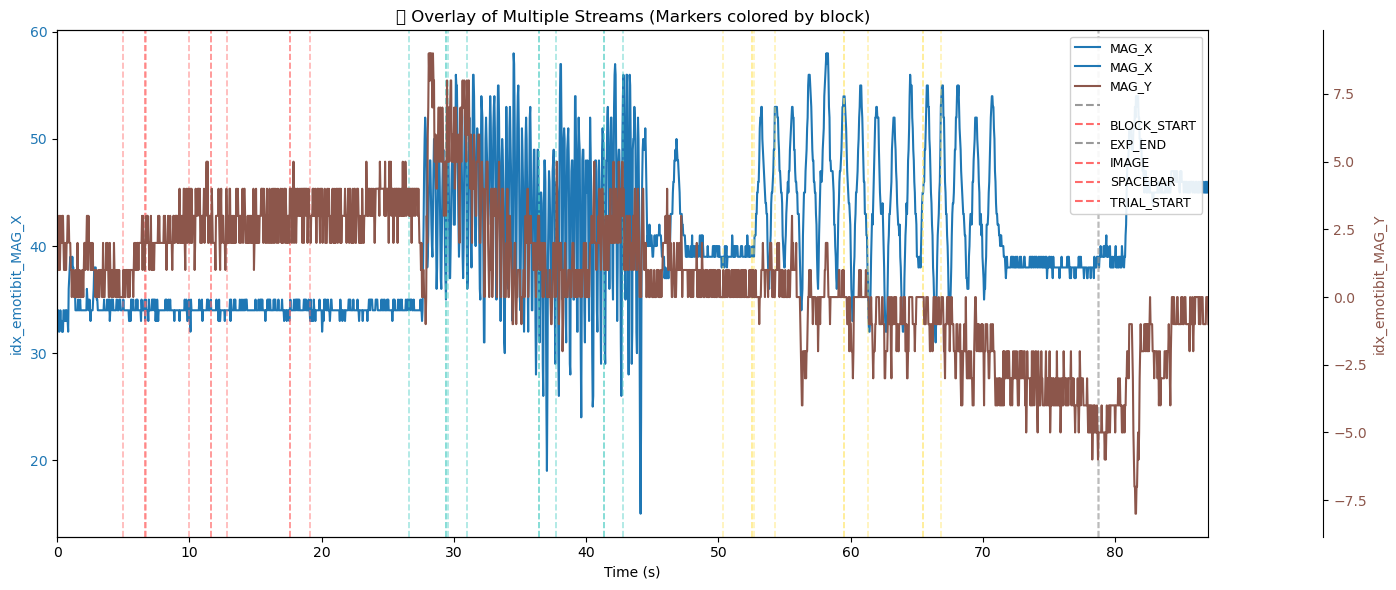

In [158]:
idx_emotibit_MAG_X = explorer.get_stream_index("MAG_X")
idx_emotibit_MAG_Y = explorer.get_stream_index("MAG_Y")
idx_emotibit_MAG_Z = explorer.get_stream_index("MAG_Z")
idx_emotibit_PPG_RED = explorer.get_stream_index("PPG_RED")
idx_emotibit_EDA = explorer.get_stream_index("EDA")
idx_markers = explorer.get_stream_index("Markers")

# Plot HR (ch 3), MAG_X (ch 0), and Markers
explorer.plot_streams(
    indices=[
        idx_emotibit_MAG_X, 
        idx_emotibit_MAG_Y, 
        # idx_emotibit_MAG_Z, 
        # idx_emotibit_EDA,
        # idx_emotibit_PPG_RED,
        idx_markers
        ],
    channels_per_stream=[[0], [0], None],
    max_duration=6000,
    labels=[
        "idx_emotibit_MAG_X", 
        "idx_emotibit_MAG_Y", 
        # "idx_emotibit_MAG_Z", 
        # "PPG_RED", 
        "Markers"
    ]
)


In [ ]:
explorer.plot_continuous(4)
explorer.plot_markers(1)


In [32]:
explorer.plot_emotibit_all()


⚠️ Stream containing 'emotibit' not found.
